In [1]:
import pandas as pd
import numpy as np
import os
import json

import datetime
from datetime import date, timedelta

#from tqdm.notebook import tqdm
from tqdm import tqdm_notebook

from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller


from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error


import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

In [2]:
trend_series = pd.read_excel('trend_series1.xlsx')
trend_series

,date,danceability,duration,tempo,valence
0,2017-01-05,0.671298,224694.764649,120.316054,0.481959
1,2017-01-12,0.672296,224426.472864,120.268173,0.482855
2,2017-01-19,0.673306,224159.678521,120.220389,0.483811
3,2017-01-26,0.674331,223893.759996,120.172949,0.484824
4,2017-02-02,0.675373,223628.464650,120.126102,0.485889
...,...,...,...,...,...
327,2023-04-13,0.666852,201659.224005,124.322663,0.510844
328,2023-04-20,0.667009,201625.772548,124.376448,0.511650
329,2023-04-27,0.667121,201586.229053,124.430288,0.512444
330,2023-05-04,0.667187,201540.822008,124.484120,0.513223


In [3]:
trend_series = pd.read_excel('trend_series1.xlsx')
trend_series["date"] = pd.to_datetime(trend_series["date"])

danceability_trend = trend_series["danceability"]
duration_trend = trend_series["duration"]
tempo_trend = trend_series["tempo"]
valence_trend = trend_series["valence"]

In [4]:
trend_series_clean=trend_series.set_index('date')
trend_series_clean

,danceability,duration,tempo,valence
date,,,,
2017-01-05,0.671298,224694.764649,120.316054,0.481959
2017-01-12,0.672296,224426.472864,120.268173,0.482855
2017-01-19,0.673306,224159.678521,120.220389,0.483811
2017-01-26,0.674331,223893.759996,120.172949,0.484824
2017-02-02,0.675373,223628.464650,120.126102,0.485889
...,...,...,...,...
2023-04-13,0.666852,201659.224005,124.322663,0.510844
2023-04-20,0.667009,201625.772548,124.376448,0.511650
2023-04-27,0.667121,201586.229053,124.430288,0.512444


In [32]:
maxlag = 4
test = 'ssr_chi2test'
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
    """Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. The values in the table 
    are the P-Values. P-Values lesser than the significance level (0.05), implies 
    the Null Hypothesis that the coefficients of the corresponding past values is 
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

grangers_causation_matrix(trend_series_clean, variables = trend_series_clean.columns)

,danceability_x,duration_x,tempo_x,valence_x
danceability_y,1.0000,0.0000,0.0000,0.0000
duration_y,0.0000,1.0000,0.0000,0.0000
tempo_y,0.0000,0.0000,1.0000,0.0754
valence_y,0.0004,0.0175,0.0264,1.0000


In [6]:
def adfuller_test(series, signif=0.05, name='', verbose=False):
    """Perform ADFuller to test for Stationarity of given series and print report"""
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue'] 
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.")

In [7]:
for c in trend_series_clean.columns:
    print('-'*3,c,'-'*3)
    adfuller_test(trend_series_clean[c])

--- danceability ---
    Augmented Dickey-Fuller Test on "" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -1.2473
 No. Lags Chosen       = 14
 Critical value 1%     = -3.451
 Critical value 5%     = -2.871
 Critical value 10%    = -2.572
 => P-Value = 0.6529. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.
--- duration ---
    Augmented Dickey-Fuller Test on "" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -2.5157
 No. Lags Chosen       = 14
 Critical value 1%     = -3.451
 Critical value 5%     = -2.871
 Critical value 10%    = -2.572
 => P-Value = 0.1117. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.
--- tempo ---
    Augmented Dickey-Fuller Test on "" 
    --------------------------------------------

In [8]:
def cointegration_test(df, alpha=0.05): 
    """Perform Johanson's Cointegration Test and Report Summary"""
    out = coint_johansen(df,-1,7)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = out.lr1
    cvts = out.cvt[:, d[str(1-alpha)]]
    
    def adjust(val, length= 6): 
        return str(val).ljust(length)

    # Summary
    print('Name   ::  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print(adjust(col), ':: ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)

    print(out.trace_stat)
cointegration_test(trend_series_clean)

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
danceability ::  34.73     > 40.1749   =>   False
duration ::  12.97     > 24.2761   =>   False
tempo  ::  4.66      > 12.3212   =>   False
valence ::  2.13      > 4.1296    =>   False
[34.73004095 12.97098212  4.66385315  2.12671825]


In [9]:
nobs = 8
trend_series_clean_train, trend_series_clean_test = trend_series_clean[0:-nobs], trend_series_clean[-nobs:]

# Check size
print(trend_series_clean_train.shape)  # (119, 8)
print(trend_series_clean_test.shape)  # (4, 8)

(324, 4)
(8, 4)


In [10]:
for c in trend_series_clean.columns:
    print('-'*3,c,'-'*3)
    adfuller_test(trend_series_clean_train[c])

--- danceability ---
    Augmented Dickey-Fuller Test on "" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -1.1254
 No. Lags Chosen       = 15
 Critical value 1%     = -3.452
 Critical value 5%     = -2.871
 Critical value 10%    = -2.572
 => P-Value = 0.7049. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.
--- duration ---
    Augmented Dickey-Fuller Test on "" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -2.4999
 No. Lags Chosen       = 14
 Critical value 1%     = -3.452
 Critical value 5%     = -2.871
 Critical value 10%    = -2.572
 => P-Value = 0.1155. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.
--- tempo ---
    Augmented Dickey-Fuller Test on "" 
    --------------------------------------------

In [11]:
trend_series_differenced = trend_series_clean_train.diff().dropna()

In [12]:
for c in trend_series_clean.columns:
    print('-'*3,c,'-'*3)
    adfuller_test(trend_series_differenced[c])

--- danceability ---
    Augmented Dickey-Fuller Test on "" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -3.9424
 No. Lags Chosen       = 14
 Critical value 1%     = -3.452
 Critical value 5%     = -2.871
 Critical value 10%    = -2.572
 => P-Value = 0.0017. Rejecting Null Hypothesis.
 => Series is Stationary.
--- duration ---
    Augmented Dickey-Fuller Test on "" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -3.962
 No. Lags Chosen       = 13
 Critical value 1%     = -3.452
 Critical value 5%     = -2.871
 Critical value 10%    = -2.572
 => P-Value = 0.0016. Rejecting Null Hypothesis.
 => Series is Stationary.
--- tempo ---
    Augmented Dickey-Fuller Test on "" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non

In [13]:
model = VAR(trend_series_differenced)

In [33]:
for i in [1,2,3,4,5,6,7,8,9]:
    result = model.fit(i)
    print('Lag Order =', i)
    print('AIC : ', result.aic)
    print('BIC : ', result.bic)
    print('HQIC: ', result.hqic, '\n')

Lag Order = 1
AIC :  -34.38847805858632
BIC :  -34.15403386321089
HQIC:  -34.29488046865571 

Lag Order = 2
AIC :  -42.42708212397769
BIC :  -42.004116764374324
HQIC:  -42.258202465500865 

Lag Order = 3
AIC :  -44.777315585819125
BIC :  -44.164963424002636
HQIC:  -44.53279174470649 

Lag Order = 4
AIC :  -45.48784672977409
BIC :  -44.68523546021494
HQIC:  -45.16731378599031 

Lag Order = 5
AIC :  -45.593575362600184
BIC :  -44.59982594073372
HQIC:  -45.19666556040891 

Lag Order = 6
AIC :  -45.72750070815903
BIC :  -44.54172727791383
HQIC:  -45.25384342596872 

Lag Order = 7
AIC :  -45.66046010690019
BIC :  -44.28176992722904
HQIC:  -45.10968182670455 

Lag Order = 8
AIC :  -45.65560918905881
BIC :  -44.08310255945568
HQIC:  -45.02733346546534 

Lag Order = 9
AIC :  -45.70375489135297
BIC :  -43.93652507633889
HQIC:  -44.99760232019288 



In [15]:
n_lags = 4
model_fitted = model.fit(n_lags)
model_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 12, Jul, 2023
Time:                     20:27:59
--------------------------------------------------------------------
No. of Equations:         4.00000    BIC:                   -44.6852
Nobs:                     319.000    HQIC:                  -45.1673
Log likelihood:           5512.75    FPE:                1.75815e-20
AIC:                     -45.4878    Det(Omega_mle):     1.42843e-20
--------------------------------------------------------------------
Results for equation danceability
                     coefficient       std. error           t-stat            prob
----------------------------------------------------------------------------------
const                  -0.000003         0.000004           -0.587           0.557
L1.danceability         2.182270         0.079195           27.556           0.000
L1.duration            -0.000002         0.00

In [16]:
# Mengambil orde dari lag
lag_order = model_fitted.k_ar
print(lag_order)  

# Input data untuk forecasting
forecast_input = trend_series_differenced.values[-lag_order:]
forecast_input

4


array([[ 5.16441139e-04, -3.56566735e+00,  6.24575003e-02,
         1.24720242e-03],
       [ 3.60222170e-04, -1.41102004e+01,  6.00681938e-02,
         1.09204110e-03],
       [ 3.33065129e-04, -1.25765470e+01,  5.76121409e-02,
         1.00348331e-03],
       [ 3.20374807e-04, -1.16739840e+01,  5.59004686e-02,
         9.40540183e-04]])

In [34]:
fc = model_fitted.forecast(y=forecast_input, steps=nobs)
df_forecast = pd.DataFrame(fc, index=trend_series_clean.index[-nobs:], columns=trend_series_clean.columns + '_d')
df_forecast

,danceability_d,duration_d,tempo_d,valence_d
date,,,,
2023-03-23,0.000275,-14.923867,0.053773,0.000894
2023-03-30,0.000199,-21.214085,0.050158,0.000867
2023-04-06,0.000103,-29.834657,0.044972,0.000851
2023-04-13,0.000002,-40.082520,0.038717,0.000834
2023-04-20,-0.000090,-51.341431,0.032133,0.000804
2023-04-27,-0.000166,-62.988308,0.025893,0.000754
2023-05-04,-0.000225,-74.440484,0.020451,0.000686
2023-05-11,-0.000268,-85.194365,0.015990,0.000604


In [18]:
def invert_transformation(df_train, df_forecast, second_diff=False):
    """Revert back the differencing to get the forecast to original scale."""
    df_fc = df_forecast.copy()
    columns = df_train.columns
    for col in columns:        
        # Roll back 2nd Diff
        if second_diff:
            df_fc[str(col)+'_1d'] = (df_train[col].iloc[-1]-df_train[col].iloc[-2]) + df_fc[str(col)+'_2d'].cumsum()
        # Roll back 1st Diff
        df_fc[str(col)+'_forecast'] = df_train[col].iloc[-1] + df_fc[str(col)+'_1d'].cumsum()
    return df_fc

In [19]:
df_results = invert_transformation(trend_series_clean, df_forecast, second_diff=True)
df_results.loc[:,['danceability_forecast','duration_forecast',
                 'tempo_forecast','valence_forecast']]

,danceability_forecast,duration_forecast,tempo_forecast,valence_forecast
date,,,,
2023-03-23,0.667504,201424.465504,124.645361,0.515639
2023-03-30,0.667999,201337.611234,124.803027,0.518161
2023-04-06,0.668597,201220.922307,125.005664,0.521533
2023-04-13,0.669197,201064.150859,125.247019,0.525740
2023-04-20,0.669707,200856.037981,125.520507,0.530751
2023-04-27,0.670050,200584.936795,125.819888,0.536516
2023-05-04,0.670169,200239.395124,126.139720,0.542968
2023-05-11,0.670020,199808.659088,126.475542,0.550024


In [20]:
test_series = df_results.loc[:,['danceability_forecast','duration_forecast',
                 'tempo_forecast','valence_forecast']]

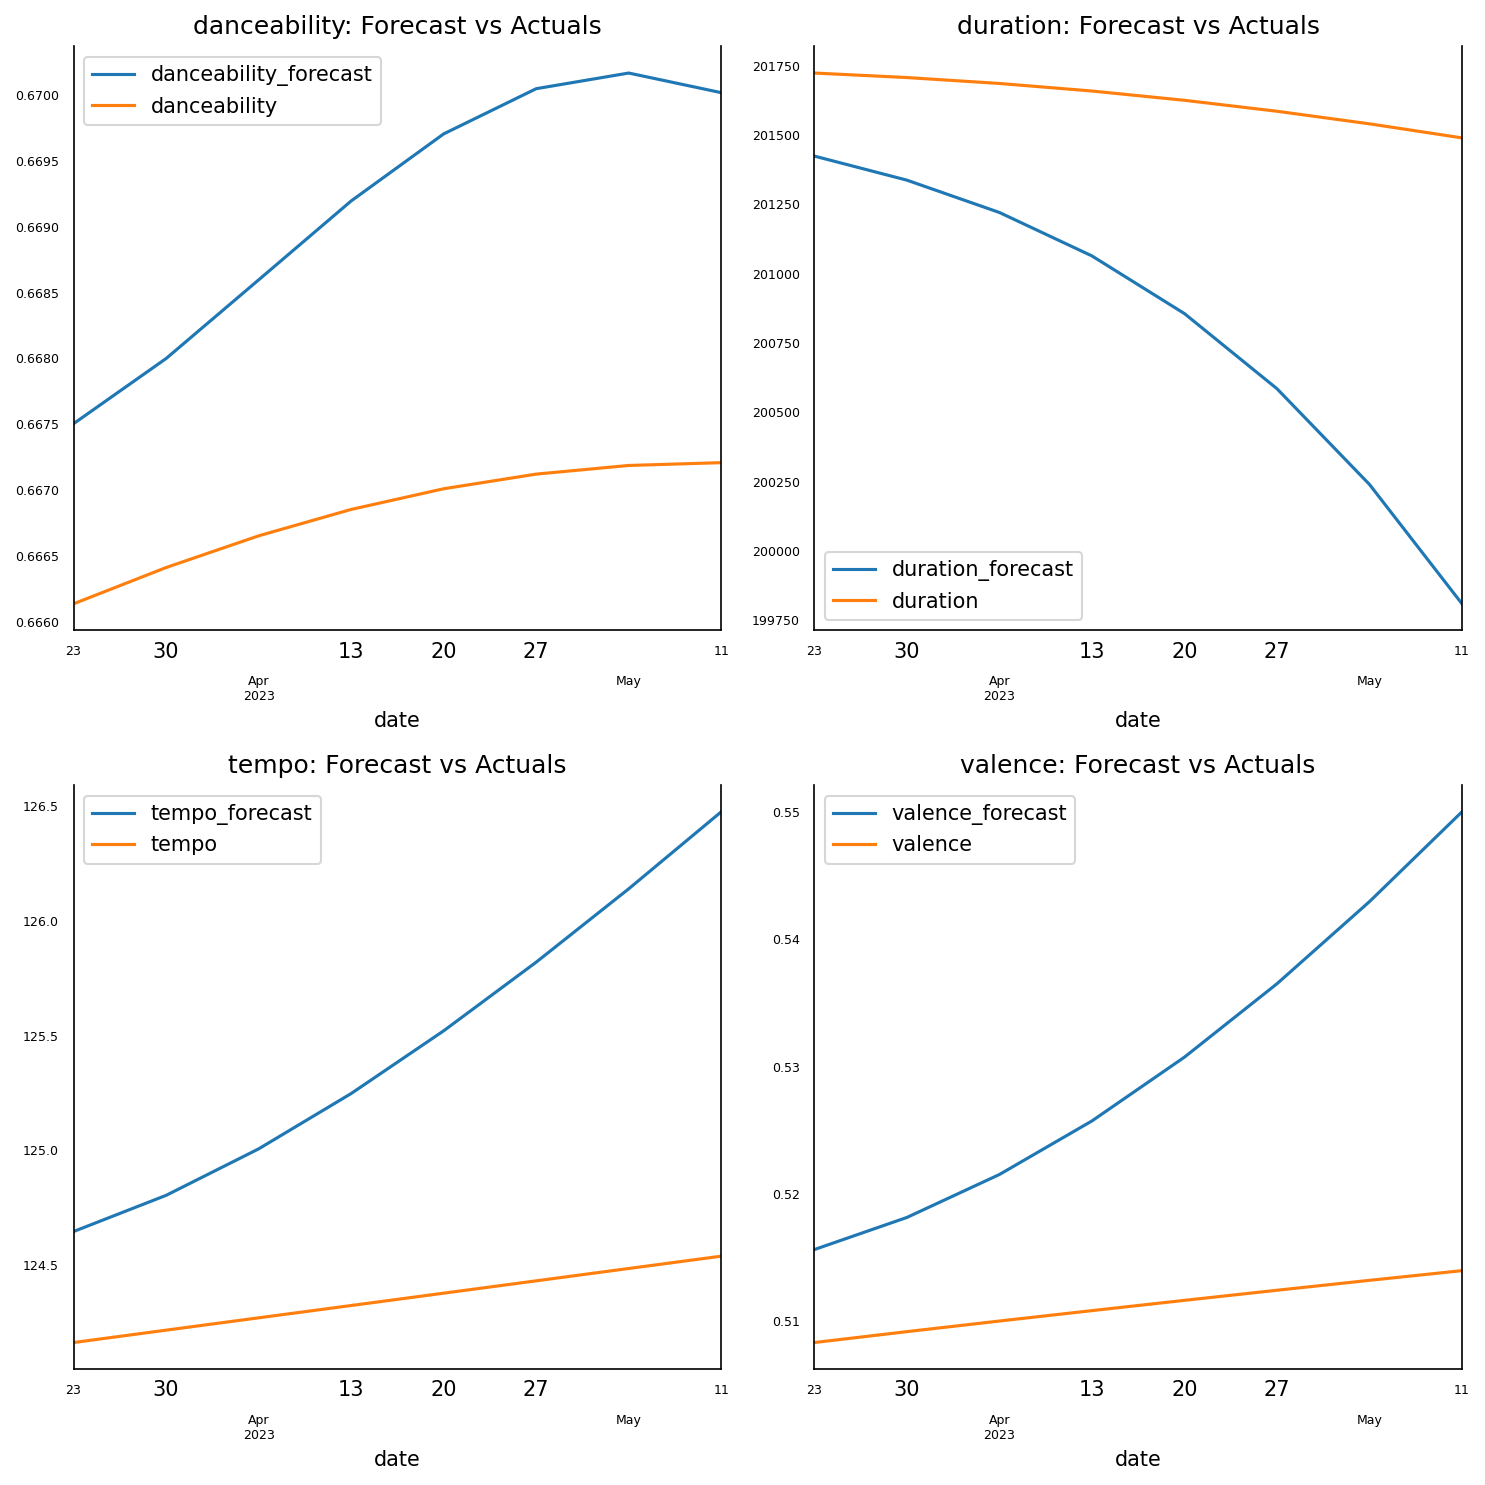

In [21]:
fig, axes = plt.subplots(nrows=int(len(trend_series_clean.columns)/2), ncols=2, dpi=150, figsize=(10,10))
for i, (col,ax) in enumerate(zip(trend_series_clean.columns, axes.flatten())):
    df_results[col+'_forecast'].plot(legend=True, ax=ax).autoscale(axis='x',tight=True)
    trend_series_clean_test[col][-nobs:].plot(legend=True, ax=ax);
    ax.set_title(col + ": Forecast vs Actuals")
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();
plt.savefig('forecast.png')

In [22]:
trend_series_clean_test

,danceability,duration,tempo,valence
date,,,,
2023-03-23,0.666135,201724.132849,124.161198,0.508337
2023-03-30,0.666411,201707.867968,124.215230,0.509193
2023-04-06,0.666652,201686.523673,124.268972,0.510026
2023-04-13,0.666852,201659.224005,124.322663,0.510844
2023-04-20,0.667009,201625.772548,124.376448,0.511650
2023-04-27,0.667121,201586.229053,124.430288,0.512444
2023-05-04,0.667187,201540.822008,124.484120,0.513223
2023-05-11,0.667208,201490.105690,124.537854,0.513984


In [36]:
from statsmodels.tsa.stattools import acf
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    mae = np.mean(np.abs(forecast - actual))    # MAE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    return({'mape':mape, 'mae': mae, 'rmse':rmse})

def adjust(val, length= 6): return str(val).ljust(length)
print('Forecast Accuracy of: Danceability')
accuracy_prod = forecast_accuracy(df_results['danceability_forecast'].values, trend_series_clean_test['danceability'])
for k, v in accuracy_prod.items():
    print(adjust(k), ': ', round(v,4))

print('\nForecast Accuracy of: Duration')
accuracy_prod = forecast_accuracy(df_results['duration_forecast'].values, trend_series_clean_test['duration'])
for k, v in accuracy_prod.items():
    print(adjust(k), ': ', round(v,4))

print('\nForecast Accuracy of: Tempo')
accuracy_prod = forecast_accuracy(df_results['tempo_forecast'].values, trend_series_clean_test['tempo'])
for k, v in accuracy_prod.items():
    print(adjust(k), ': ', round(v,4))

print('\nForecast Accuracy of: Valence')
accuracy_prod = forecast_accuracy(df_results['valence_forecast'].values, trend_series_clean_test['valence'])
for k, v in accuracy_prod.items():
    print(adjust(k), ': ', round(v,4))


Forecast Accuracy of: Danceability
mape   :  0.0035
mae    :  0.0023
rmse   :  0.0024

Forecast Accuracy of: Duration
mape   :  0.004
mae    :  810.5624
rmse   :  929.6397

Forecast Accuracy of: Tempo
mape   :  0.0089
mae    :  1.1075
rmse   :  1.21

Forecast Accuracy of: Valence
mape   :  0.037
mae    :  0.019
rmse   :  0.0213


In [24]:
df_results['danceability_forecast'].values

array([0.6675042 , 0.66799937, 0.66859715, 0.66919698, 0.66970677,
       0.67005041, 0.6701694 , 0.67002025])

In [25]:
trend_series_clean_test['danceability']

date
2023-03-23    0.666135
2023-03-30    0.666411
2023-04-06    0.666652
2023-04-13    0.666852
2023-04-20    0.667009
2023-04-27    0.667121
2023-05-04    0.667187
2023-05-11    0.667208
Name: danceability, dtype: float64